In [2]:
import sys
import os

notebook_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(parent_dir)

In [3]:
from lss.brownian import BrownianMotionSimulation
from src.plots import show_simulations
from lss.regression_models.naive_model import NaiveModel
from lss.longstaff_schwartz import LongStaffSchwartz
from lss.out_of_sample import OutOfSample
from lss.option.put_option import PutOption

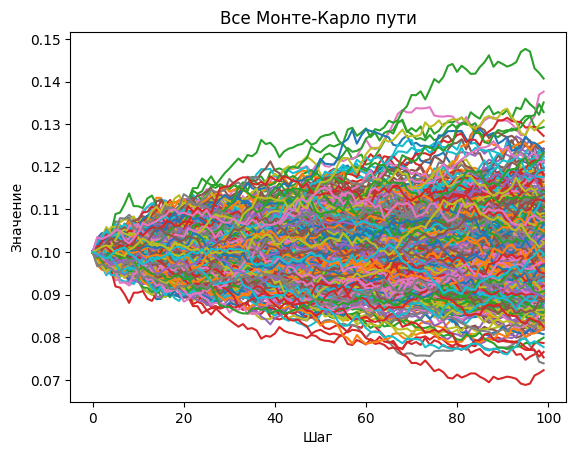

In [4]:
brownian = BrownianMotionSimulation(S_0=0.1, risk_free_rate=5, volatility=20)

paths = brownian.simulate(num_paths=500, len_paths=100)

show_simulations(paths)

### Как в статье

In [5]:
from devtools import pprint
import numpy as np

In [6]:
# ========== PARAMS =============
r = 2190.1757087015604
K = 1.1
mkp = np.array(
    [
        [1, 1.09, 1.08, 1.34],
        [1, 1.16, 1.26, 1.54],
        [1, 1.22, 1.07, 1.03],
        [1, 0.93, 0.97, 0.92],
        [1, 1.11, 1.56, 1.52],
        [1, 0.76, 0.77, 0.90],
        [1, 0.92, 0.84, 1.01],
        [1, 0.88, 1.22, 1.34],
    ]
)
#================================

In [7]:
algo = LongStaffSchwartz(
    risk_free_rate=r,
    strike=K,
    model=NaiveModel(risk_free_rate=r),
    monte_carlo_paths=mkp
)

algo.evaluate(verbose=True)

----- INITIAL CASH FLOW MATRIX -----
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
------------------------------------
----- CASH FLOW MATRIX AT TIME 3-----
[[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.07]
 [0.   0.   0.18]
 [0.   0.   0.  ]
 [0.   0.   0.2 ]
 [0.   0.   0.09]
 [0.   0.   0.  ]]
------------------------------------
----- CASH FLOW MATRIX AT TIME 2 -----
[[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.07]
 [0.   0.13 0.  ]
 [0.   0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.26 0.  ]
 [0.   0.   0.  ]]
-----------------------------------------
----- CASH FLOW MATRIX AT TIME 1 -----
[[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.07]
 [0.17 0.   0.  ]
 [0.   0.   0.  ]
 [0.34 0.   0.  ]
 [0.18 0.   0.  ]
 [0.22 0.   0.  ]]
-----------------------------------------
----- DECISION MATRIX -----
[[0 0 0]
 [0 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
---------------------------


In [8]:
backtest = OutOfSample(
    risk_free_rate=r,
    strike=K,
    models_list=algo.models_list,
    monte_carlo_paths=mkp
)

backtest.evaluate()

In [9]:
print(f"American Put price\n\tLSS : {algo.american_option_price}\n\tOOS : {backtest.american_option_price}")
print(f"European Put price\n\tLSS : {algo.european_option_price}\n\tOOS : {backtest.european_option_price}")
print(f"Interval with 95% of confidence: {algo.confident_interval()}")
print("----------------------------")
print("MODEL PARAMETERS")
pprint(algo)

American Put price
	LSS : 0.10712520000000003
	OOS : 0.10712520000000003
European Put price
	LSS : 0.05637992503615492
	OOS : 0.05637992503615492
Interval with 95% of confidence: 0.19506158776763735
----------------------------
MODEL PARAMETERS
LongStaffSchwartz(
    risk_free_rate=2190.1757087015603,
    strike=1.1,
    option=PutOption(
    ),
    model=NaiveModel(
        risk_free_rate=2190.1757087015603,
    ),
    monte_carlo_paths=(
        array([[1.  , 1.09, 1.08, 1.34],
               [1.  , 1.16, 1.26, 1.54],
               [1.  , 1.22, 1.07, 1.03],
               [1.  , 0.93, 0.97, 0.92],
               [1.  , 1.11, 1.56, 1.52],
               [1.  , 0.76, 0.77, 0.9 ],
               [1.  , 0.92, 0.84, 1.01],
               [1.  , 0.88, 1.22, 1.34]])
    ),
    cash_flow_matrix=(
        array([[0.  , 0.  , 0.  ],
               [0.  , 0.  , 0.  ],
               [0.  , 0.  , 0.07],
               [0.17, 0.  , 0.  ],
               [0.  , 0.  , 0.  ],
               [0.34, 

### Эксперименты


Проверим правильность реализации in sample и out of sample, то что цены американского и европеского опыионов должны совпадать

In [12]:
import numpy as np

# -------------------
NUM_PATHS = 20000
PATH_LEN = 100
STRIKE = 1900
START_REAL_PRICE = 2000
RISK_FREE_RATE = 10.0
VOLATILITY = 150 
# --------------------

brownian = BrownianMotionSimulation(
    S_0=START_REAL_PRICE, 
    risk_free_rate=RISK_FREE_RATE,
    volatility=VOLATILITY,
)

simulations = brownian.simulate(num_paths=NUM_PATHS, len_paths=PATH_LEN)
naive_model = NaiveModel(risk_free_rate=RISK_FREE_RATE)

algo = LongStaffSchwartz(
    risk_free_rate=RISK_FREE_RATE,
    option=PutOption(),
    strike=STRIKE,
    monte_carlo_paths=simulations,
    model=naive_model
)

algo.evaluate(verbose=False)

simulations_ofs = brownian.simulate(num_paths=NUM_PATHS, len_paths=PATH_LEN)

backtest = OutOfSample(
    risk_free_rate=RISK_FREE_RATE,
    option=PutOption(),
    strike=STRIKE,
    monte_carlo_paths=simulations_ofs,
    models_list=algo.models_list
)
backtest.evaluate()

print(f"American Put price\n\tLSS : {algo.american_option_price}\n\tOOS : {backtest.american_option_price}")
print(f"European Put price\n\tLSS : {algo.european_option_price}\n\tOOS : {backtest.european_option_price}")
print(f"Interval with 95% of confidence: {algo.confident_interval()}")

American Put price
	LSS : 471.3373074623328
	OOS : 473.65420716047043
European Put price
	LSS : 511.3696443169729
	OOS : 513.0966371440883
Interval with 95% of confidence: 0.9548828081135184


In [11]:
from math import log, sqrt, exp
from scipy.stats import norm

def d1(S, K, T, r, sigma):
    return(log(S/K) + (r + sigma**2/2.) * T) / (sigma * sqrt(T))


def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma * sqrt(T)


def bs_put(S, K, T, r, sigma):
    return K * exp(-r * T) * norm.cdf(-1 * d2(S, K, T, r, sigma)) - S * norm.cdf(-1 * d1(S, K, T, r, sigma))

    
euro_put = bs_put(
    S=START_REAL_PRICE,
    K=STRIKE, 
    T=PATH_LEN/365, 
    r=RISK_FREE_RATE/100,
    sigma=VOLATILITY/100
)
print(f"European Put by Black-Scholes formula: {euro_put}")

European Put by Black-Scholes formula: 261.50203304306035


In [10]:
from tqdm.notebook import tqdm

# ------- ENVS -------
# --------------------
NUM_PATHS = 10000
PATH_LEN = 20
STRIKE = 1900
START_REAL_PRICE = 2000
RISK_FREE_RATE = 5.0
VOLATILITY = 50 
STRIKE_STEP = 1
# --------------------
# --------------------

prices_in_sample = []
prices_out_of_sample = []
strike = []
conf_intervals = []

brownian = BrownianMotionSimulation(S_0=START_REAL_PRICE, risk_free_rate=RISK_FREE_RATE, volatility=VOLATILITY)
lss_paths = brownian.simulate(num_paths=NUM_PATHS, len_paths=PATH_LEN)
oos_paths = brownian.simulate(num_paths=NUM_PATHS, len_paths=PATH_LEN)

naive_model = NaiveModel(risk_free_rate=RISK_FREE_RATE)
option_model = PutOption()

In [12]:
for i in tqdm(range(800)):

    strike.append(STRIKE)
    
    lss_model = LongStaffSchwartz(
        risk_free_rate=RISK_FREE_RATE,
        option=option_model,
        strike=STRIKE,
        monte_carlo_paths=lss_paths,
        model=naive_model
    )
    lss_model.evaluate(verbose=False)
    
    models_after_train: list = list(lss_model.models_list)
    
    oos_model = OutOfSample(
        risk_free_rate=RISK_FREE_RATE,
        models_list=models_after_train,
        strike=STRIKE,
        option=option_model,
        monte_carlo_paths=oos_paths
    )
    oos_model.evaluate()

    STRIKE += STRIKE_STEP
    conf_intervals.append(lss_model.confident_interval())
    prices_in_sample.append(lss_model.american_option_price)
    prices_out_of_sample.append(oos_model.american_option_price)


  0%|          | 0/800 [00:00<?, ?it/s]

In [13]:
up_border = [x + y for x, y in zip(prices_in_sample, conf_intervals)]
low_border = [x - y for x, y in zip(prices_in_sample, conf_intervals)]

In [16]:
len(prices_in_sample), len(prices_out_of_sample), len(strike)

(800, 800, 801)

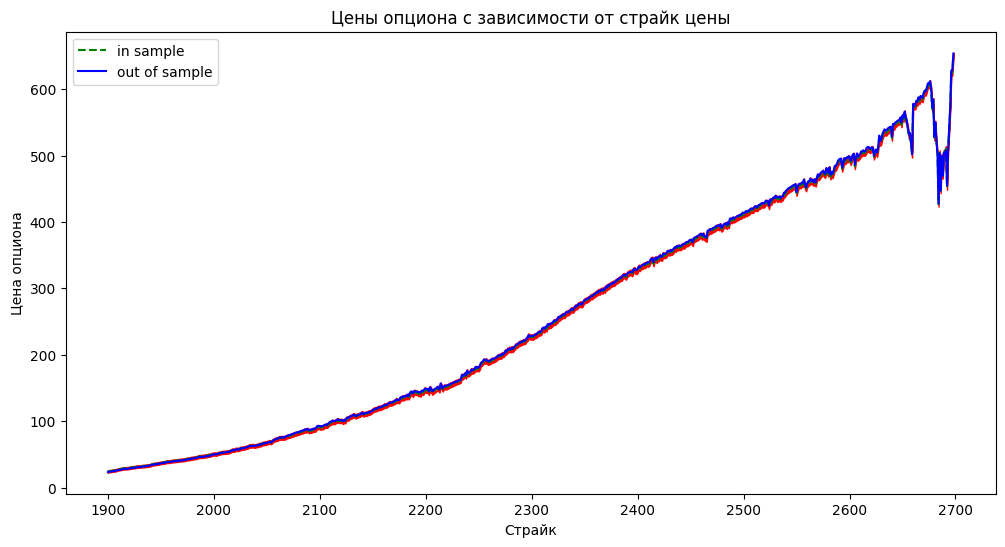

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(strike[:-1], prices_in_sample, linestyle='--', color='g', label='in sample')
plt.plot(strike[:-1], prices_out_of_sample, linestyle='-', color='b', label='out of sample')
plt.ylabel('Цена опциона')
plt.xlabel('Cтрайк')
ax.fill_between(strike[:-1], up_border, low_border, color='r')
plt.legend()
plt.title("Цены опциона с зависимости от страйк цены")
plt.show()

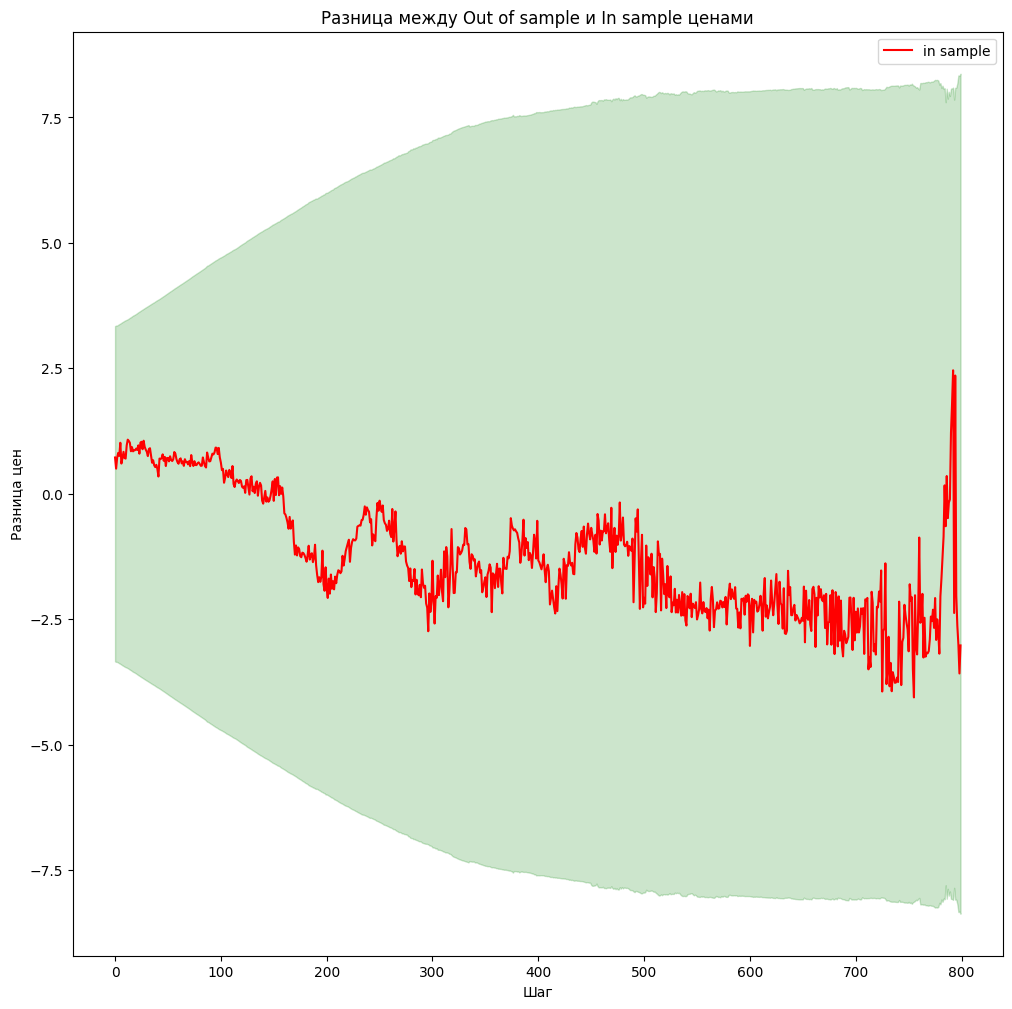

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(
    np.arange(0,len(prices_out_of_sample)),
    np.array(prices_in_sample) - np.array(prices_out_of_sample), 
    linestyle='-',
    color='r', 
    label='in sample'
)
plt.fill_between(
    np.arange(0,len(prices_out_of_sample)),
    np.array(up_border) - np.array(low_border),
    np.array(low_border) - np.array(up_border),
    color='g',
    alpha=0.2,
)
plt.ylabel('Разница цен')
plt.xlabel('Шаг')
plt.legend()
plt.title("Разница между Out of sample и In sample ценами")
plt.show()